# Calculating spacing 

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from skysurvey.tools import utils
import skysurvey
from skysurvey import effects
from skysurvey import dataset
from skysurvey import Survey




In [84]:
#https://lsstcomcam.lsst.io/


#Version 1: FOV-based Spacing 
print("----")

FOV = 40 #40'x40'
FOV_deg = FOV/60 #60 arcmin in 1 deg
FOV_area = FOV_deg**2
spacing = FOV_deg / 3  # 0.6667 / 3 = 0.2222 deg


print(f"Converting from a 40'x40' to {FOV_deg:.2f}x{FOV_deg:.2f}deg, we get {FOV_area:.2f} in degrees.")
print(f"Without modeling exact gemoetry (including edge gaps or CCD frames), we approximate the spacing between grids to be {spacing:.3f} degrees")
print("----")

#Version 2: Geometry-based spacing 
print("----")

CCD = 4000 #pixels
plate_Scale = 0.2 #arcsec/pixel
angular_Size = CCD * plate_Scale
angular_Size_deg = angular_Size / 3600
raft = angular_Size_deg * 3 # 3x3 CCDs


print(f"{angular_Size} arcseconds")
print(f"Each CCD spans (tile centers) ~{angular_Size_deg:.3f} degrees with no overlap or gap.")
print(f"A ComCam raft is 3 CCDs wide, spanning {raft:.3f} deg total.")

# Each CCD spans 




----
Converting from a 40'x40' to 0.67x0.67deg, we get 0.44 in degrees.
Without modeling exact gemoetry (including edge gaps or CCD frames), we approximate the spacing between grids to be 0.222 degrees
----
----
800.0 arcseconds
Each CCD spans (tile centers) ~0.222 degrees with no overlap or gap.
A ComCam raft is 3 CCDs wide, spanning 0.667 deg total.


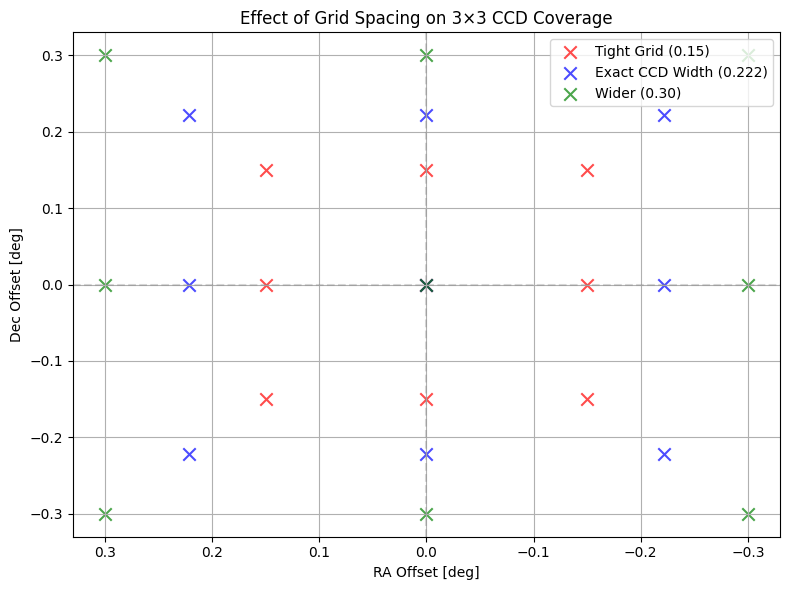

In [86]:


# Function to generate RA/Dec grid centered at (0, 0) for a given spacing
def generate_grid(spacing_deg, label):
    offsets = [-spacing_deg, 0, spacing_deg]
    ra_vals, dec_vals = [], []
    for dx in offsets:
        for dy in offsets:
            ra_vals.append(dx)
            dec_vals.append(dy)
    return np.array(ra_vals), np.array(dec_vals), label

# Spacings to compare (deg)
spacings = {
    "Tight Grid (0.15)": 0.15,
    "Exact CCD Width (0.222)": 0.222,
    "Wider (0.30)": 0.30
}

# Plot setup
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']

for (label, spacing), color in zip(spacings.items(), colors):
    ra, dec, _ = generate_grid(spacing, label)
    plt.scatter(ra, dec, label=label, s=80, alpha=0.7, c=color, marker='x')

plt.axhline(0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(0, color='gray', linestyle='--', alpha=0.3)
plt.xlabel("RA Offset [deg]")
plt.ylabel("Dec Offset [deg]")
plt.title("Effect of Grid Spacing on 3×3 CCD Coverage")
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Pulling in LSST ComCam-like FOV

In this notebook, I’m using real Rubin DP1 visit data from the ECDFS, EDFS, Fornax, and LELF fields to simulate what the detection of Type Ia supernovae would look like if they occurred during that period. I start by loading the observation metadata (pointings, MJDs, filters, depths) from the DP1 Parquet logs and convert it into a format compatible with skysurvey. I model the ComCam field of view as a 40′×40′ square and build a Survey object using the real visits, excluding y-band since it falls outside the wavelength range of the SN Ia templates. Then, I inject 10,000 synthetic SNe Ia randomly distributed in time and sky position, with Milky Way extinction applied. Finally, I simulate whether and how those SNe would have been observed by the survey, producing synthetic light curves that reflect the actual DP1 cadence and depth

In [90]:
import pandas as pd
from skysurvey.tools.utils import get_skynoise_from_maglimit
from shapely.geometry import box
from skysurvey import SNeIa, effects
from skysurvey import dataset
from astropy.coordinates import SkyCoord
import astropy.units as u




df = pd.read_parquet("dp1_visits-ECDFS_EDFS_Fornax_LELF.parquet")
print(df.columns)


Index(['visit', 'ra', 'dec', 'band', 'mjd', 'limitingMagnitude', 'seeing'], dtype='object')


In [92]:

def from_dp1_parquet(filepath, zp=30):
    df = pd.read_parquet(filepath)

    simdata = pd.DataFrame({
        "skynoise": df["limitingMagnitude"].apply(get_skynoise_from_maglimit, zp=zp).values,
        "mjd": df["mjd"].values,
        "band": "lsst" + df["band"].values,  # e.g., 'lsstr', 'lssti'
        "gain": 1,
        "zp": zp,
        "ra": df["ra"].values,
        "dec": df["dec"].values
    }, index=df.index)

    return simdata


In [94]:
simdata = from_dp1_parquet("dp1_visits-ECDFS_EDFS_Fornax_LELF.parquet")
simdata.head()


,skynoise,mjd,band,gain,zp,ra,dec
0,41.121599,60623.258521,lssti,1,30,53.327236,-28.072055
1,28.491151,60623.259329,lsstr,1,30,53.327425,-28.072347
2,27.501096,60623.259895,lsstr,1,30,53.141378,-28.131211
3,41.659111,60623.260739,lssti,1,30,53.141304,-28.131213
4,43.330130,60623.261307,lssti,1,30,53.188483,-28.208666


In [96]:

# This models the full 40′ × 40′ field
FOV_deg = 40 / 60  # degrees
half_size = FOV_deg / 2

# Centered at (0, 0)
footprint = box(-half_size, -half_size, half_size, half_size)

simdata = simdata[~(simdata["band"] == "lssty")].reset_index(drop=True)


survey = Survey.from_pointings(simdata, footprint=footprint)


In [128]:
def draw_uniform_circle(n, ra_center, dec_center, radius_deg):
    """
    Uniformly draw `n` points within a circular patch of radius `radius_deg`
    centered at (ra_center, dec_center).
    """
    radius_rad = np.deg2rad(radius_deg)
    u_r = np.sqrt(np.random.uniform(0, 1, n)) * radius_rad  # ensures uniformity over area
    theta = np.random.uniform(0, 2 * np.pi, n)

    delta_ra = (u_r * np.cos(theta)) / np.cos(np.deg2rad(dec_center))
    delta_dec = u_r * np.sin(theta)

    ra = ra_center + np.rad2deg(delta_ra)
    dec = dec_center + np.rad2deg(delta_dec)

    return ra, dec

In [136]:

field_centers = {
    "47 Tuc": [6.02, -72.08],
    "SV 38 7": [37.86, 6.98],
    "Fornax": [40.00, -34.45],
    "ECDFS": [53.13, -28.10],
    "EDFS": [59.10, -48.73],
    "SV 95 -25": [95.00, -25.00],
    "Seagull": [106.23, -10.51],
}

#n_targets = 10000
tstart = simdata["mjd"].min()
tstop  = simdata["mjd"].max()

# You can apply extinction if desired
#snia = SNeIa.from_draw(n_targets, tstart=tstart, tstop=tstop, effect=effects.mw_extinction)

n_targets_per_field = 1000  # or 500, etc.
radius_deg = 0.5  # roughly LSST FOV scale

ras, decs = [], []

for name, (ra_c, dec_c) in field_centers.items():
    ra_drawn, dec_drawn = draw_uniform_circle(n_targets_per_field, ra_c, dec_c, radius_deg)
    ras.extend(ra_drawn)
    decs.extend(dec_drawn)


# Draw SNe at these positions
snia = SNeIa.from_draw(
    len(ras),
    tstart=tstart,
    tstop=tstop,
    ra=ras,
    dec=decs,
    effect=effects.mw_extinction,
)

KeyError: 'ra'

In [99]:

dset = dataset.DataSet.from_targets_and_survey(
    snia,
    survey,
    discard_bands=["lssty"]  # This avoids trying to simulate y-band light curves
)
dset.data

detections = dset.get_data(detection=True)


/Users/andradenebula/Documents/Research/Transient_Metrics/Rubin_Data_Preview_SNe/skysurvey-env/lib/python3.12/site-packages/skysurvey/dataset.py:726: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()


In [118]:
detections = detections.reset_index(drop=True)  # don't keep old index as a column
target_positions = dset.targets.data[["ra", "dec"]].reset_index()  # adds 'index'

# Now merge using the new numeric index
detections["index"] = target_positions["index"]  # assume row order is preserved

# Or, if you want to be more explicit:
detections = pd.concat([detections, target_positions[["ra", "dec"]]], axis=1)

print(detections.columns)
print(detections[["ra", "dec"]].head())

# Load Felipe's real DIA detections and keep extended (galaxy-hosted) objects
dia_df = pd.read_parquet("dp1_detections-ECDFS_EDFS_Fornax_LELF.parquet")
dia_df = dia_df[dia_df["refExtendedness"] == 1].reset_index(drop=True)



# Get SkyCoord arrays for matching
det_snia_coords = SkyCoord(ra=detections["ra"].values * u.deg,
                           dec=detections["dec"].values * u.deg)
dia_coords = SkyCoord(ra=dia_df["coord_ra"].values * u.deg,
                      dec=dia_df["coord_dec"].values * u.deg)


# Perform nearest-neighbor match
idx, sep2d, _ = det_snia_coords.match_to_catalog_sky(dia_coords)

# Create mask for matches within 1 arcsec
match_mask = sep2d < 1.0 * u.arcsec

# Add boolean flag to detections DataFrame
detections["matched_to_dia"] = match_mask

# Optional: you can also add the match separation
detections["match_sep_arcsec"] = sep2d.arcsec

# Summary print
n_matched = match_mask.sum()
print(f"Simulated SNe matched to DIA detections: {n_matched} / {len(detections)}")



Index(['level_0', 'index', 'index_obs', 'fieldid', 'band', 'mjd', 'zp',
       'zpsys', 'gain', 'skynoise', 'flux', 'fluxerr', 'ra_x', 'dec_x', 'ra_y',
       'dec_y', 'ra', 'dec'],
      dtype='object')
           ra        dec
0   51.036701 -19.978449
1   96.048241 -31.406626
2  286.235321 -59.601288
3  234.275055  -0.734621
4  316.814423 -17.093542
Simulated SNe matched to DIA detections: 0 / 10000
